### Import the necessary libraries

In [0]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# System related libraries
import os
import re
# Handle table-like data and matrices
import numpy as np
np.random.seed(21)
import pandas as pd
# sklearn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.manifold import TSNE
## Bokeh libraries
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
# NLTK libraries
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
## Plotting Libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
# Data Visualization
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Download the datasets using PyDrive Client

In [0]:
# Read text file into colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Download the [Liar Liar Dataset](https://drive.google.com/file/d/1y3yYF5HHPhH7SyaPwPU9H5HApJzevsFK/view)

[Description about the dataset](https://drive.google.com/open?id=1Ranl1lYPT9aqujmnfKQJLbysdaxebQ3k)

In [0]:
# Google drive link where the dataset is stored.
link = 'https://drive.google.com/open?id=1YVbguC-ZVf7D0fit5Hhq4cgBLrNWcvAR'
fluff, id = link.split('=')
# Download the tsv file.
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.tsv')
link = 'https://drive.google.com/open?id=1YVbguC-ZVf7D0fit5Hhq4cgBLrNWcvAR'
fluff, id = link.split('=')
# Download the text file.
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('valid.tsv')

Download the [Kaggle Fake News Dataset](https://www.kaggle.com/c/8317/download-all)

In [0]:
# Google drive link where the dataset is stored.
link = 'https://drive.google.com/open?id=19N9D6JONrA75Pd32hl228UoCxZs4K2cF'
fluff, id = link.split('=')
# Download the text file.
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('fake_news_train.csv')

Download the [Kaggle Fake News Detection Dataset](https://www.kaggle.com/jruvika/fake-news-detection)

In [0]:
# Google drive link where the dataset is stored.
link = 'https://drive.google.com/open?id=1KEvvfmHNE4v_TvZxOYGuMiPYJxpk30XT'
fluff, id = link.split('=')
# Download the text file.
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data.csv')

###Data Pre-processing

In [0]:
# Read the training and valid data from files
col_names = ['jsonid', 'target', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytrueocunts','pantsonfirecounts','context']

train_news = pd.read_csv('train.tsv', sep='\t', names = col_names, error_bad_lines=False)
valid_news = pd.read_csv('valid.tsv', sep='\t', names = col_names, error_bad_lines=False)

In [0]:
# Display check the dimensions and the first 2 rows of the file.
print('Liar Liar Dataset')
print('train dim:',train_news.shape, 'valid dim:', valid_news.shape)
train_news.iloc[0:2]

Liar Liar Dataset
train dim: (10240, 14) valid dim: (10240, 14)


,jsonid,target,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


In [0]:
liar = pd.concat([train_news,valid_news])

In [0]:
liar['text']=liar['headline_text']

In [0]:
def cleaning(raw_text):  
    text = re.sub("[^a-zA-Z]", " ", str(raw_text))
    text =  text.lower()
    text_words = nltk.word_tokenize(text)
    stops = set(nltk.corpus.stopwords.words("english"))
    words = [w for w in  text_words  if not w in stops]
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    return " ".join(stems)

In [0]:
liar['clean_text'] = liar['text'].apply(cleaning)

In [0]:
train = pd.read_csv('fake_news_train.csv')

In [0]:
# Display check the dimensions and the first 2 rows of the file.
print('Fake News Dataset')
print('Dataset dimension:',train.shape)
train.iloc[0:2]

Fake News Dataset
Dataset dimension: (20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0


In [0]:
train = train.dropna(how='any',axis=0) 

In [0]:
train = train[['text']]

In [0]:
train['clean_text'] = train['text'].apply(cleaning)

In [0]:
train_fake = pd.read_csv('data.csv')
print('Kaggle Fake News Detection Dataset')
print('Dataset dimension:',train_fake.shape)
train_fake.iloc[0:2]

Kaggle Fake News Detection Dataset
Dataset dimension: (4009, 4)


,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1


In [0]:
train_fake['text'] = train_fake['Body']
train_fake = train_fake[['text']]

In [0]:
train_fake = train_fake.dropna(how='any',axis=0)
train_fake['clean_text'] = train_fake['text'].apply(cleaning)

### Data Amalgamation

In [0]:
liar = liar[['clean_text']]

In [0]:
train = train[['clean_text']]

In [0]:
train_fake = train_fake[['clean_text']]

In [0]:
df = pd.concat([liar,train,train_fake])

In [0]:
df.head()

,clean_text
0,say anni list polit group support third trimes...
1,declin coal start start natur gas took start b...
2,hillari clinton agre john mccain vote give geo...
3,health care reform legisl like mandat free sex...
4,econom turnaround start end term


###Perform LDA 

In [0]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words=stop_words)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['clean_text'])

Generate 10 topics on Amalgamated Dataset Corpus with the LDA model

In [0]:
l = []
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        l.append(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1,random_state=21)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
said state unit russia govern mr countri militari war attack

Topic #1:
said year one health dr like research peopl percent studi

Topic #2:
game said play team time week one first year season

Topic #3:
clinton mr trump hillari elect campaign said email vote investig

Topic #4:
compani tax million year state percent billion new news money

Topic #5:
said mr one year peopl day famili like citi time

Topic #6:
peopl one world american like war govern medium power time

Topic #7:
trump presid mr said obama republican hous democrat peopl american

Topic #8:
like one new time show work film look music way

Topic #9:
said polic state offic law court mr report case school


### Data Narative

Top 10 Common Words

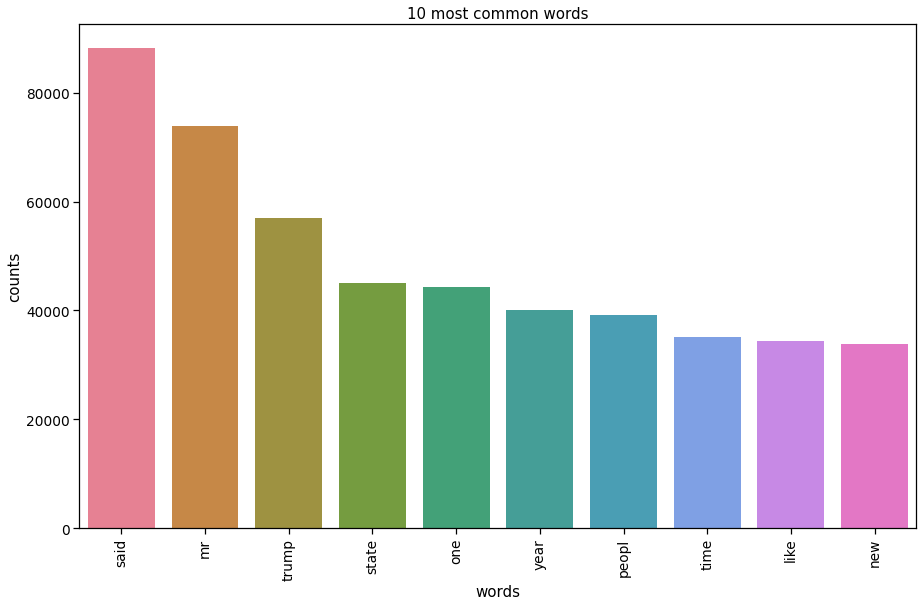

In [0]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [0]:
gen_docs = [[w.lower() for w in word_tokenize(text)] for text in df['clean_text']]

In [0]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(gen_docs)

In [0]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in gen_docs]

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=21,
                                           per_word_topics=True)

Word Clouds of Top N Keywords in Each Topic

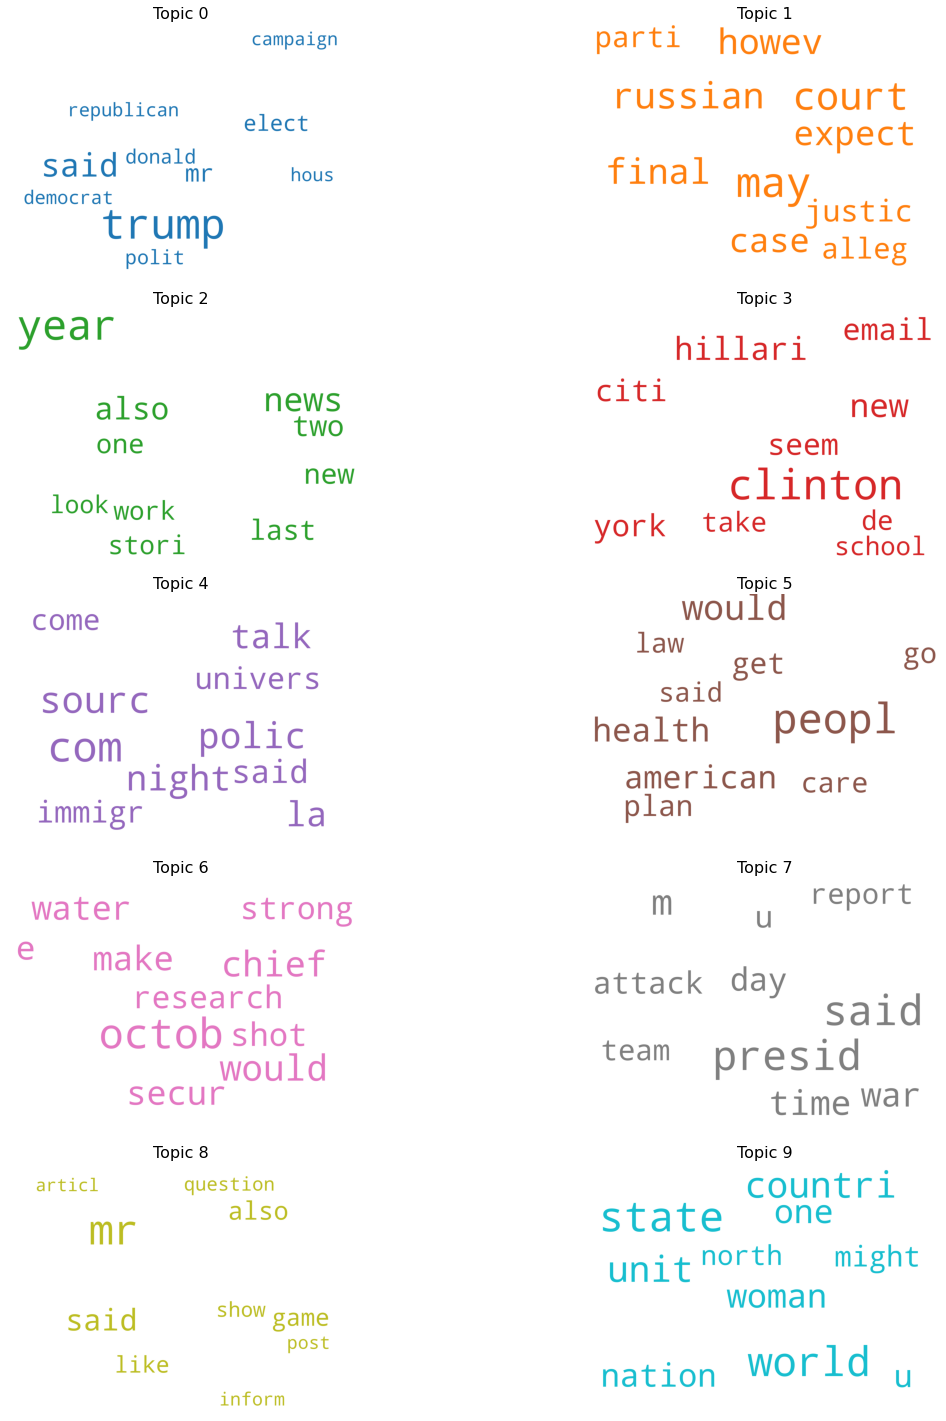

In [0]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

t-SNE Clustering Chart

In [0]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 31092 samples in 0.054s...
[t-SNE] Computed neighbors for 31092 samples in 2.387s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31092
[t-SNE] Computed conditional probabilities for sample 2000 / 31092
[t-SNE] Computed conditional probabilities for sample 3000 / 31092
[t-SNE] Computed conditional probabilities for sample 4000 / 31092
[t-SNE] Computed conditional probabilities for sample 5000 / 31092
[t-SNE] Computed conditional probabilities for sample 6000 / 31092
[t-SNE] Computed conditional probabilities for sample 7000 / 31092
[t-SNE] Computed conditional probabilities for sample 8000 / 31092
[t-SNE] Computed conditional probabilities for sample 9000 / 31092
[t-SNE] Computed conditional probabilities for sample 10000 / 31092
[t-SNE] Computed conditional probabilities for sample 11000 / 31092
[t-SNE] Computed conditional probabilities for sample 12000 / 31092
[t-SNE] Computed conditional probabilities for sam

In [0]:
!pip install pyLDAvis

pyLDAvis to visualise the information contained in a topic model.

In [0]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

Dominant topic and its percentage contribution in each document of Liar Liar Dataset

In [0]:
liar_gen_docs = [[w.lower() for w in word_tokenize(text)] for text in liar['clean_text']]
id2word = gensim.corpora.Dictionary(liar_gen_docs)
liar_corpus = [id2word.doc2bow(text) for text in liar_gen_docs]

In [0]:
liar_lda_model = gensim.models.ldamodel.LdaModel(corpus=liar_corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=21,
                                           per_word_topics=True)

In [0]:
def format_topics_sentences(ldamodel=None, corpus=liar_corpus, texts=liar_gen_docs):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=liar_lda_model, corpus=liar_corpus, texts=liar_gen_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.6377,"percent, rate, tax, american, unemploy, incom,...","[say, anni, list, polit, group, support, third..."
1,1,3.0,0.5590,"say, vote, presid, obama, u, clinton, senat, r...","[declin, coal, start, start, natur, gas, took,..."
2,2,5.0,0.4066,"say, cut, tax, romney, medicar, billion, secur...","[hillari, clinton, agre, john, mccain, vote, g..."
3,3,8.0,0.4947,"year, health, tax, care, percent, state, incre...","[health, care, reform, legisl, like, mandat, f..."
4,4,2.0,0.8500,"state, say, billion, budget, oil, feder, new, ...","[econom, turnaround, start, end, term]"
5,5,8.0,0.5969,"year, health, tax, care, percent, state, incre...","[chicago, bear, start, quarterback, last, year..."
6,6,8.0,0.3977,"year, health, tax, care, percent, state, incre...","[jim, dunnam, live, district, repres, year]"
7,7,4.0,0.8018,"say, trump, presid, donald, obama, said, bill,...","[person, stage, work, activ, last, year, pass,..."
8,8,7.0,0.7827,"peopl, year, gun, say, law, one, percent, numb...","[howev, took, million, oregon, lotteri, fund, ..."
9,9,5.0,0.9470,"say, cut, tax, romney, medicar, billion, secur...","[say, gop, primari, oppon, glenn, grothman, jo..."
